In [1]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.utils import class_weight
%matplotlib inline

In [4]:
df=pd.read_csv('Customer_Churn_Modelling.csv', encoding='latin1',dtype={'CustomerId':str})
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [6]:
df=df.drop(['RowNumber','CustomerId','Surname'],axis='columns')

In [ ]:
#Rename column replacing whitespace with underscore
df.rename(columns= lambda x : x.replace(' ','_') if ' ' in x else x, inplace=True)
#Remove row with any columns are NA
df = df.dropna(how='any')

### Label Encoding

In [9]:
from sklearn import preprocessing
le_Gender = preprocessing.LabelEncoder()
df['Gender']=le_Gender.fit_transform(df['Gender']) 

df.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,0,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,0,41,1,83807.86,1,0,1,112542.58,0
2,502,France,0,42,8,159660.80,3,1,0,113931.57,1


In [10]:
from sklearn import preprocessing
le_Geography = preprocessing.LabelEncoder()
df['Geography']=le_Geography.fit_transform(df['Geography']) 

df.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1


###EDA

####Correlation Matrix

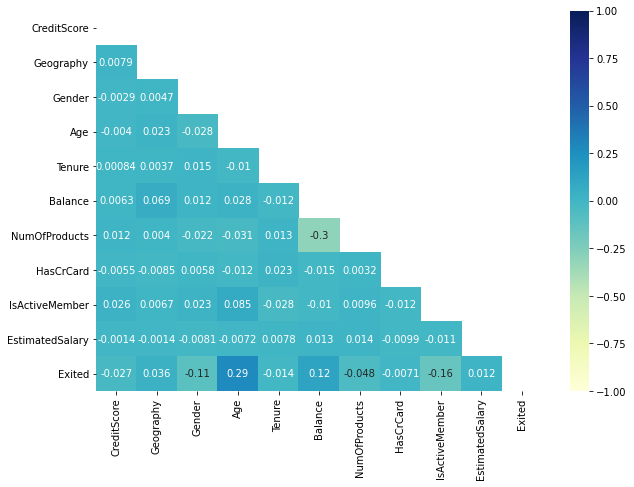

In [11]:
corr = df.corr()
mask = np.triu(corr)
#mask = np.tril(corr)
fig = plt.figure(figsize=(10,7))
sns.heatmap(corr, vmin=-1,vmax=1,annot=True, fmt='.2g',cmap='YlGnBu',mask=mask,annot_kws={"size": 10})
b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

####Distribution Plot

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

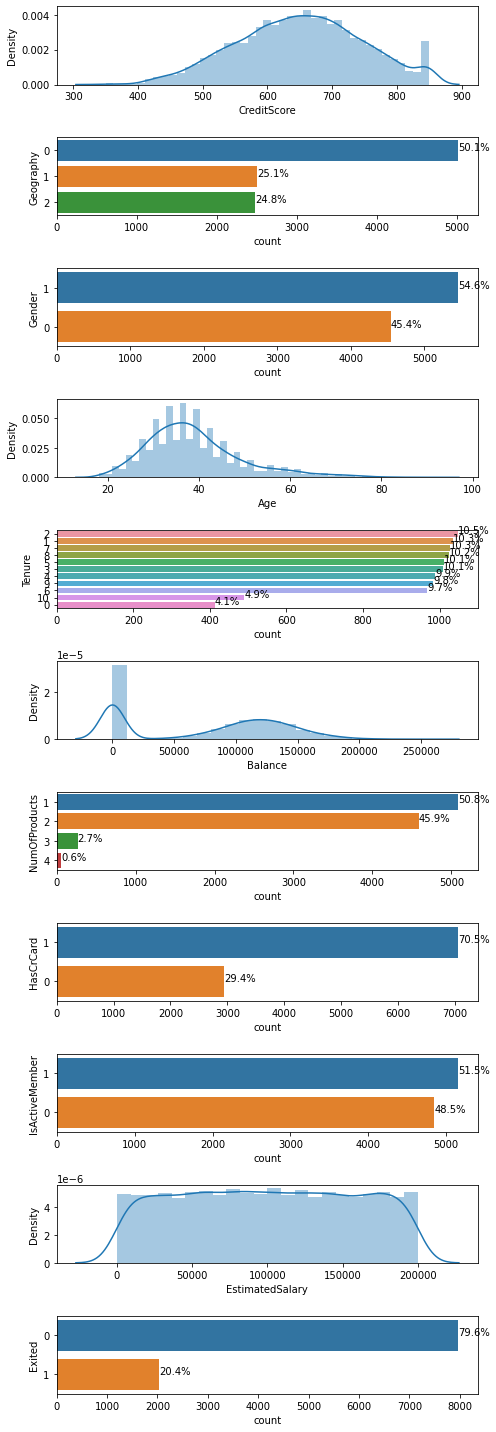

In [12]:
cols = df.columns
fig = plt.figure(figsize = (7,20) ) 
for counter,col in enumerate(cols):
    plt.subplot(len(cols),1,counter+1)
    orient = 'v'
    not_dist_plot = True
    num_level = df[col].nunique()
    
    if (num_level <= 15):
      ax = sns.countplot(y=col, data=df, order = df[col].value_counts().index)
      orient = 'h'
    elif (num_level >= 15 and num_level < 50):
      ax = sns.countplot(x=col, data=df,order = df[col].value_counts().index)
    elif (num_level >= 50):
      if  df[col].dtypes!='O' :
        ax = sns.distplot(df[col].dropna() , kde = True )
        not_dist_plot = False
      else :
        ax = sns.countplot(x=col, data=df,order = df[col].value_counts().index)      
    #plt.title(col)
    
    #Create anotation
    if orient=='h':
      total = len(df[col])
      for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))
    elif (orient=='v' and not_dist_plot) :
      total = len(df[col])
      for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + (p.get_width()/8)
        y = p.get_height()+ 2
        ax.annotate(percentage, (x, y))     
    #plt.show()
    plt.tight_layout()

#### Target Class Proportion

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


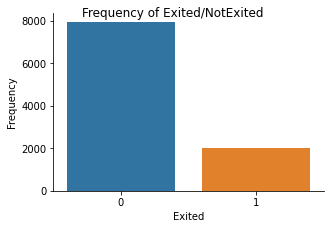

In [13]:
g = sns.catplot("Exited", data=df, kind='count',height=3, aspect=1.5)
g.set_ylabels("Frequency")
g.fig.suptitle("Frequency of Exited/NotExited")
g.fig.show()

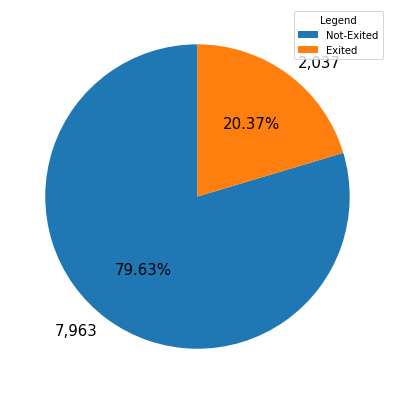

In [14]:
flag_taker_Pie=df['Exited'].value_counts().reset_index(name='count').rename(columns={'index':'Exited'})
flag_taker_Pie.plot(kind='pie', y = 'count', autopct='%1.2f%%', startangle=90, shadow=False, labels=['{:,}'.format(x) for x in flag_taker_Pie['count']], legend = True, fontsize=15, figsize=(7,7))
#plt.title("Combo Package Taker : 1=Yes , 0= No")
plt.legend(title='Legend', loc='upper right', labels=['Not-Exited', 'Exited'])
plt.xlabel('')
plt.ylabel('')
plt.show()

#### Feature to Target Plot

In [15]:
df_melt = df.melt(id_vars=['Exited'])
df_melt.head(3)

,Exited,variable,value
0,1,CreditScore,619.0
1,0,CreditScore,608.0
2,1,CreditScore,502.0


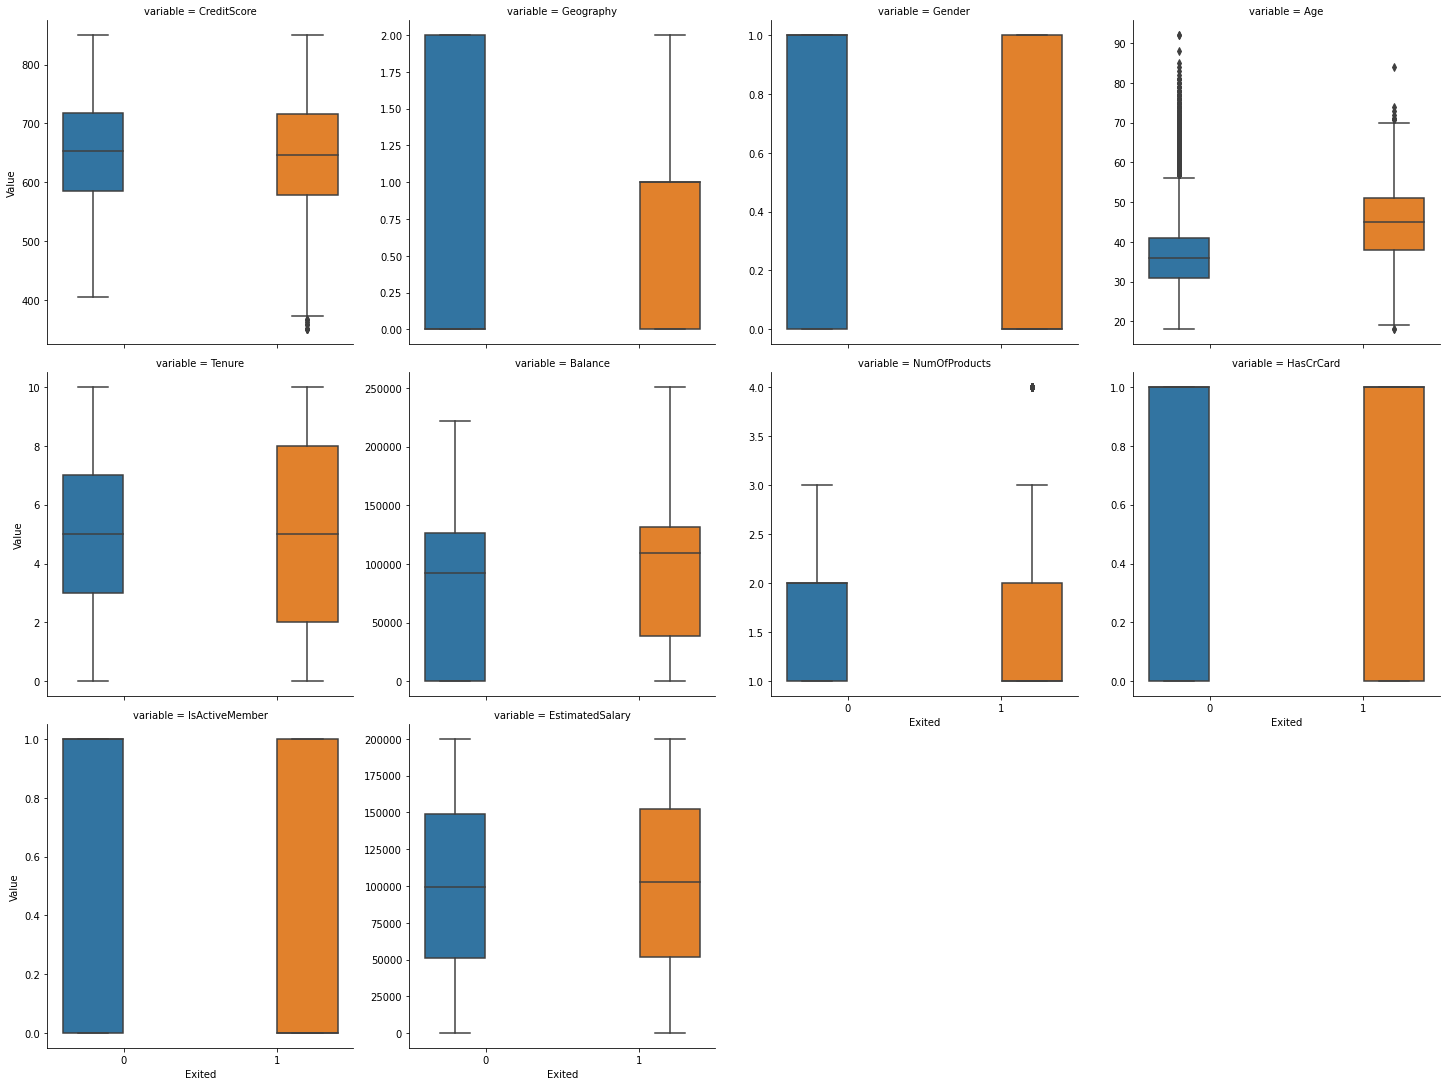

In [16]:
cols=df.columns
g = sns.FacetGrid(df_melt[df_melt['variable'].isin(cols)],height=5, aspect=1, col='variable',sharey=False, col_wrap=4)
g = g.map_dataframe(sns.boxplot, x="Exited", y="value",hue='Exited', palette=sns.color_palette()) 
g.set_xlabels("Exited")
g.set_ylabels("Value")
g.fig.show()

### Feature One Hot Encoding

In [17]:
# One Hot Enccoding
from sklearn.preprocessing import OneHotEncoder
df_object = df.select_dtypes('O')
enc = OneHotEncoder()
enc.fit(df_object)
df_object_transformed = enc.transform(df_object)
OHE_df = pd.DataFrame(df_object_transformed.toarray(),columns = enc.get_feature_names(df_object.columns))
OHE_df = OHE_df.astype(int)

#Reset index of df so we can concat with OHE_df, as we previously do many operation that change the index. Otherwise, concat will produce more addtional row.
df = df.reset_index().drop(['index'], axis='columns')
#Combine df with OHE output
df = pd.concat([df,OHE_df], axis=1)
#Drop object data type features that already encoded
df = df.drop(df_object.columns, axis='columns')

df.head(3)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1


### Train Test Split

In [18]:
# Set features and target
X = df.drop('Exited',axis='columns')
y = df['Exited']

In [50]:
# Split train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, stratify=y, random_state=9988)

### Features Standardization / Scaling

In [51]:
# # Features Standardization & Scaling

# #MinMax
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(X_train)
# X_train = pd.DataFrame(scaler.transform(X_train), columns=X.columns)
# X_test = pd.DataFrame(scaler.transform(X_test),columns = X.columns)

# Standard Scaler
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train),columns = X.columns)
X_test = pd.DataFrame(scaler.transform(X_test),columns = X.columns)

### Handling Class Imbalance

In [ ]:
# #Handling Data Imbalance
# # Option : Using under-sampling
# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(sampling_strategy='majority')
# #rus = RandomUnderSampler(sampling_strategy={0: 6112,1: 3056})
# X_sm,y_sm = rus.fit_sample(X_train,y_train)
# X_train = pd.DataFrame(X_sm,columns = X.columns)
# y_train = y_sm

# # Option : Using oversampling
# from imblearn.over_sampling import SMOTE
# smote = SMOTE('not majority') #not majority -> Semua class dibuat jumlahnya sama dengan class terbanyak
# X_sm, y_sm = smote.fit_sample(X_train,y_train)
# X_train = pd.DataFrame(X_sm,columns = X_train.columns)
# y_train = y_sm

# # Option : Using class_weight
# from sklearn.utils import class_weight
# my_class_weight = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
# w_array = np.ones(y_train.shape[0], dtype = 'float')
# for i, val in enumerate(y_train):
#     w_array[i] = my_class_weight[val-1]

### Model Fitting

#### Build ANN

In [57]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten, Dense

In [55]:
X_train.shape #11 columns

(7000, 10)

In [178]:
model=Sequential()
#In the first layer you need to specify input_dim OR input_shape (For an image)
model.add(Dense(X_train.shape[1],activation='relu', input_dim= X_train.shape[1])) #Input Layer
model.add(Dense(128, activation='relu')) #Hidden layer
model.add(Dense(64, activation='relu')) #Hidden layer
model.add(Dense(32, activation='relu')) #Hidden layer
model.add(Dense(16, activation='relu')) #Hidden layer
model.add(Dense(1, activation='sigmoid')) #Ouput layer 1 neuron which would say (0-Stay or 1-Exit)

In [181]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['AUC'])
#adam uses stocasthic gradient descent
#binary_crossentropy because output will be 0 or 1 

In [182]:
#Since y_train was a panda object we need to convert into numpy array
#batch_size is used to calculate weights in stocasthic gradient descent based on the data points
#If batch_size = 1 then for every input it will update weights and takes more training time
#Here in this case for every 10 inputs update the weights
#verbose shows progress bar of the training
history = model.fit(X_train,y_train.to_numpy(),batch_size=10, epochs=10, verbose=1, validation_split=0.2)

Epoch 1/10
560/560 [==============================] - 1s 2ms/step - loss: 0.4578 - auc: 0.7206 - val_loss: 0.4141 - val_auc: 0.7444
Epoch 2/10
560/560 [==============================] - 1s 2ms/step - loss: 0.3992 - auc: 0.7989 - val_loss: 0.3908 - val_auc: 0.7934
Epoch 3/10
560/560 [==============================] - 1s 2ms/step - loss: 0.3789 - auc: 0.8199 - val_loss: 0.3648 - val_auc: 0.8114
Epoch 4/10
560/560 [==============================] - 1s 2ms/step - loss: 0.3665 - auc: 0.8350 - val_loss: 0.3598 - val_auc: 0.8202
Epoch 5/10
560/560 [==============================] - 1s 2ms/step - loss: 0.3594 - auc: 0.8436 - val_loss: 0.3658 - val_auc: 0.8135
Epoch 6/10
560/560 [==============================] - 1s 2ms/step - loss: 0.3567 - auc: 0.8456 - val_loss: 0.3641 - val_auc: 0.8176
Epoch 7/10
560/560 [==============================] - 1s 2ms/step - loss: 0.3524 - auc: 0.8519 - val_loss: 0.3568 - val_auc: 0.8221
Epoch 8/10
560/560 [==============================] - 1s 2ms/step - loss: 0.

In [183]:
test_loss,test_acc=model.evaluate(X_test,y_test)
print(test_acc)

94/94 [==============================] - 0s 1ms/step - loss: 0.3652 - auc: 0.8393
0.8392924070358276


In [185]:
#history.history

{'auc': [0.7206109762191772,
  0.7989336848258972,
  0.8199207186698914,
  0.835006833076477,
  0.8436248302459717,
  0.8455777764320374,
  0.8518610000610352,
  0.8567268252372742,
  0.8574033975601196,
  0.8618259429931641],
 'loss': [0.4577718675136566,
  0.3992263674736023,
  0.3789407014846802,
  0.3665234446525574,
  0.3594489097595215,
  0.35666152834892273,
  0.35243576765060425,
  0.3465317189693451,
  0.34650781750679016,
  0.34120920300483704],
 'val_auc': [0.7443898916244507,
  0.7933505773544312,
  0.8114096522331238,
  0.8202407956123352,
  0.8135253190994263,
  0.8175699710845947,
  0.8220847249031067,
  0.816164493560791,
  0.8203474879264832,
  0.8163379430770874],
 'val_loss': [0.41409096121788025,
  0.39077112078666687,
  0.36476558446884155,
  0.359843373298645,
  0.3657781183719635,
  0.3641490340232849,
  0.356801837682724,
  0.36503148078918457,
  0.3625645935535431,
  0.3606516718864441]}

####Plot Learning Curve

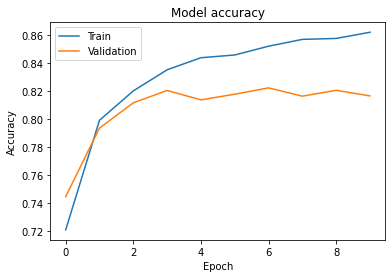

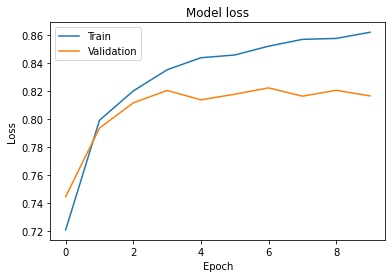

In [186]:
# Plot training & validation accuracy values
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Validation'], loc='upper left')
plt.show()

### Check model characteristic


In [ ]:
help(model)

In [187]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_25 (Dense)             (None, 128)               1408      
_________________________________________________________________
dense_26 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_27 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_28 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 17        
Total params: 12,399
Trainable params: 12,399
Non-trainable params: 0
__________________________________________________

#### SHAP Values

In [ ]:
# Shap values
!pip install shap

In [188]:
import shap
# load JS visualization code to notebook
shap.initjs()
X_shap=shap.sample(X_train, 100)
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
#explainer = shap.KernelExplainer(model.predict,X_shap)
explainer = shap.KernelExplainer(model.predict_classes,X_shap)
shap_values = explainer.shap_values(X_shap, nsamples=100)
# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)

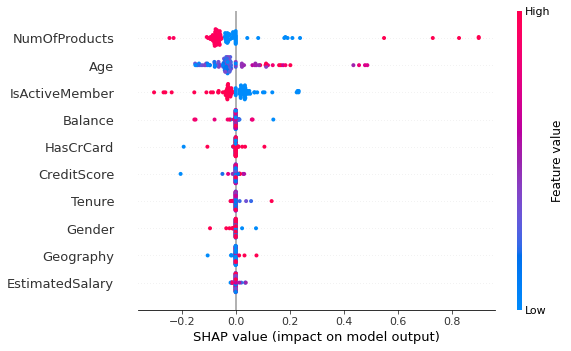

In [189]:
shap.summary_plot(shap_values[0], X_shap, plot_type='dot')

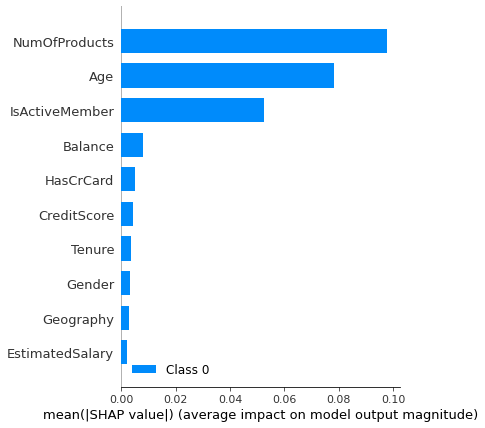

In [190]:
shap.summary_plot(shap_values, X_shap, plot_type="bar",max_display=100,plot_size=(5, 7))

### Prediction Test Dataset

In [191]:
y_pred = model.predict_classes(X_test)
y_proba_pred = model.predict_proba(X_test)

### Evaluation

#### Confusion Matrix

In [192]:
#Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[2321,   68],
       [ 376,  235]])

In [193]:
#confusion_matrix
from sklearn.metrics import confusion_matrix
df_confmat = pd.DataFrame(confusion_matrix(y_test, y_pred))
df_confmat.index.name = 'True'
df_confmat.columns.name = 'Predicted'
df_confmat

Predicted,0,1
True,,
0,2321,68
1,376,235


In [194]:
# Assess probability threshold
y_proba_pred_30 = [1. if y_cont > .3  else 0. for y_cont in y_proba_pred]
df_confmat = pd.DataFrame(confusion_matrix(y_test, y_proba_pred_30))
df_confmat.index.name = 'True'
df_confmat.columns.name = 'Predicted'
df_confmat

Predicted,0,1
True,,
0,2048,341
1,205,406


In [195]:
result = pd.DataFrame()
thresholds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
for threshold in thresholds:
  y_proba_pred_thres = [1. if y_cont > threshold  else 0. for y_cont in y_proba_pred]
  df_confmat = pd.DataFrame(confusion_matrix(y_test, y_proba_pred_thres))
  columns=[(threshold,0),(threshold,1)]
  df_confmat.columns = pd.MultiIndex.from_tuples(columns)
  df_confmat.columns.names = ['Threshold', 'Predicted']
  result = pd.concat([result.reset_index(drop=True),df_confmat.reset_index(drop=True)],axis='columns')

result.index.name = 'True'
result

Threshold   0.2        0.3        0.4       ...   0.6        0.7        0.8     
Predicted     0    1     0    1     0    1  ...     0    1     0    1     0    1
True                                        ...                                 
0          1713  676  2048  341  2234  155  ...  2340   49  2358   31  2373   16
1           122  489   205  406   311  300  ...   414  197   436  175   464  147

[2 rows x 14 columns]

In [40]:
#!pip install -U mlxtend

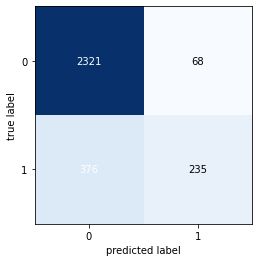

In [196]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_mat=mat, figsize=(4,4), show_normed= False)
plt.show()

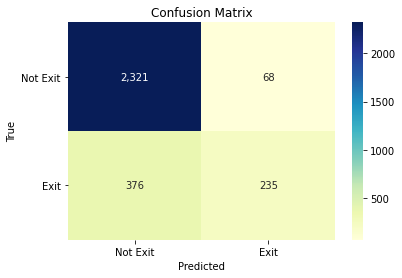

In [197]:
conf_mat= pd.DataFrame(confusion_matrix(y_test, y_pred))
fig = plt.figure(figsize=(6,4))
ax = sns.heatmap(conf_mat, annot=True, fmt=',g',cmap='YlGnBu',cbar_kws={"shrink": 1})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Not Exit','Exit'])
ax.yaxis.set_ticklabels(['Not Exit','Exit'],rotation=0)
# b, t = plt.ylim() # discover the values for bottom and top
# b += 0.5 # Add 0.5 to the bottom
# t -= 0.5 # Subtract 0.5 from the top
# plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show()

#### ROC AUC Score

In [198]:
# ROC AUC Score
from sklearn.metrics import roc_auc_score
print ('AUC Score : %0.15f' %roc_auc_score(y_test,y_proba_pred))

AUC Score : 0.839366052399192


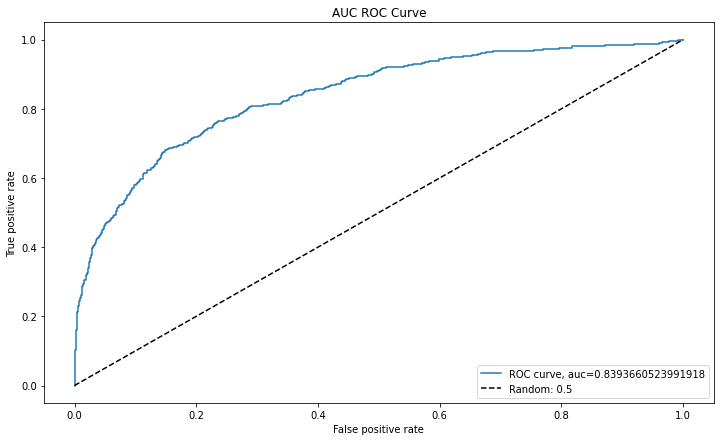

In [199]:
from sklearn import metrics
fpr, tpr, _ = metrics.roc_curve(y_test,  y_proba_pred)
auc = metrics.roc_auc_score(y_test, y_proba_pred)
plt.subplots(figsize=(12,7))
plt.plot(fpr,tpr,label="ROC curve, auc="+str(auc))
plt.plot([0,1], [0,1], 'k--', label = 'Random: 0.5')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('AUC ROC Curve')
plt.legend(loc=4)
plt.show()

#### Classification Report

In [200]:
# Classification Report
from sklearn.metrics import classification_report
class_report = classification_report(y_test, y_pred, output_dict=True)
df_class_report = pd.DataFrame(class_report).transpose()
df_class_report

,precision,recall,f1-score,support
0,0.860586,0.971536,0.912702,2389.000
1,0.775578,0.384615,0.514223,611.000
accuracy,0.852000,0.852000,0.852000,0.852
macro avg,0.818082,0.678076,0.713462,3000.000
weighted avg,0.843272,0.852000,0.831545,3000.000


In [201]:
from sklearn.metrics import precision_recall_fscore_support
prfs_score = precision_recall_fscore_support(y_test,y_pred,average='macro')
print("Precision  |  Recall  | F1 Score ")
print("%0.6f   | %0.6f | %0.6f  " % (prfs_score[0],prfs_score[1],prfs_score[2]))

Precision  |  Recall  | F1 Score 
0.818082   | 0.678076 | 0.713462  
